>**Algoritmos para Big Data**

>**2023/24**

# Binary classification
This lecture is about binary classification in a discrete space. We will setup a ML processing pipeline to achieve our goals. The dataset relates to the domain of banking industry, specifically about credit risk.

# ML pipelines

As stated in the Spark's programming guide, **"ML Pipelines provide a uniform set of high-level APIs built on top of DataFrames that help users create and tune practical machine learning pipelines."**

Hence, it is possible to combine multiple algorithms into a single pipeline, or workflow. Besides DataFrames, it involves the following:
1. Transformer: an algorithm which can transform one DataFrame into another DataFrame. For example, an ML model is a Transformer which transforms a DataFrame with features into a DataFrame with predictions.
2. Estimator: an algorithm which can be fit on a DataFrame to produce a Transformer. For example, a learning algorithm is an Estimator which trains on a DataFrame and produces a model.
3. Pipeline: the way to chain multiple Transformers and Estimators together to specify an ML workflow. 4. Parameter: all Transformers and Estimators share a common API for specifying parameters.
Further details can be found in http://spark.apache.org/docs/latest/ml-pipeline.html



Recall that, in general, a typical ML workflow is designed to work as depicted below:

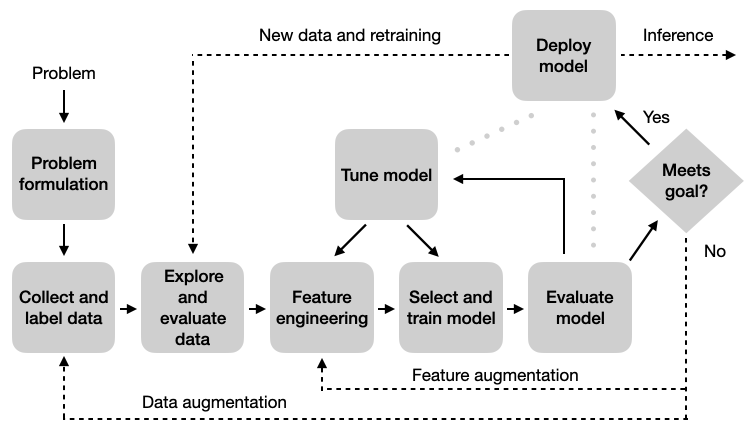

# Problem formulation

This exercise is about home credit default risk. Our case-study is based on a Kaggle dataset that has been used in a competition. Details can be found in 

>https://www.kaggle.com/competitions/home-credit-default-risk/ .

The goal is predict if a particular credit application might face payment difficulties or not. This is shown by a feature called `TARGET`. In the end, it is a binary classification problem.

Basically, the functional requirements for the Spark program we are about to create are as follows:
1. To load the datasets under analysis and making sure it can be further processed by a ML classifier.
2. To create a classification model supported by a SVM algorithm that is fit for the purpose.
3. To evaluate the quality of the classifier that has been built.

As for data availability, you can find the archive **home-credit-default.zip** in the location 

>`https://bigdata.iscte.me/abd/home-credit-default.zip` .

To solve the problem, we focus on three data files from the zip archive:
- HomeCredit_columns_description.csv
- application_train.csv
- application_test.csv

The application_train.csv and similar application_test.csv contain the most important features.

Later on, as an additional exercise, you may use all the given data to enhance the predictive power of the model.

---

**Information collected from the site of the competition**

*application_{train|test}.csv*

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

*bureau.csv*

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

*bureau_balance.csv*

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

*POS_CASH_balance.csv*

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

*credit_card_balance.csv*

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

*previous_application.csv*

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

*installments_payments.csv*

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

*HomeCredit_columns_description.csv*

This file contains descriptions for the columns in the various data files.


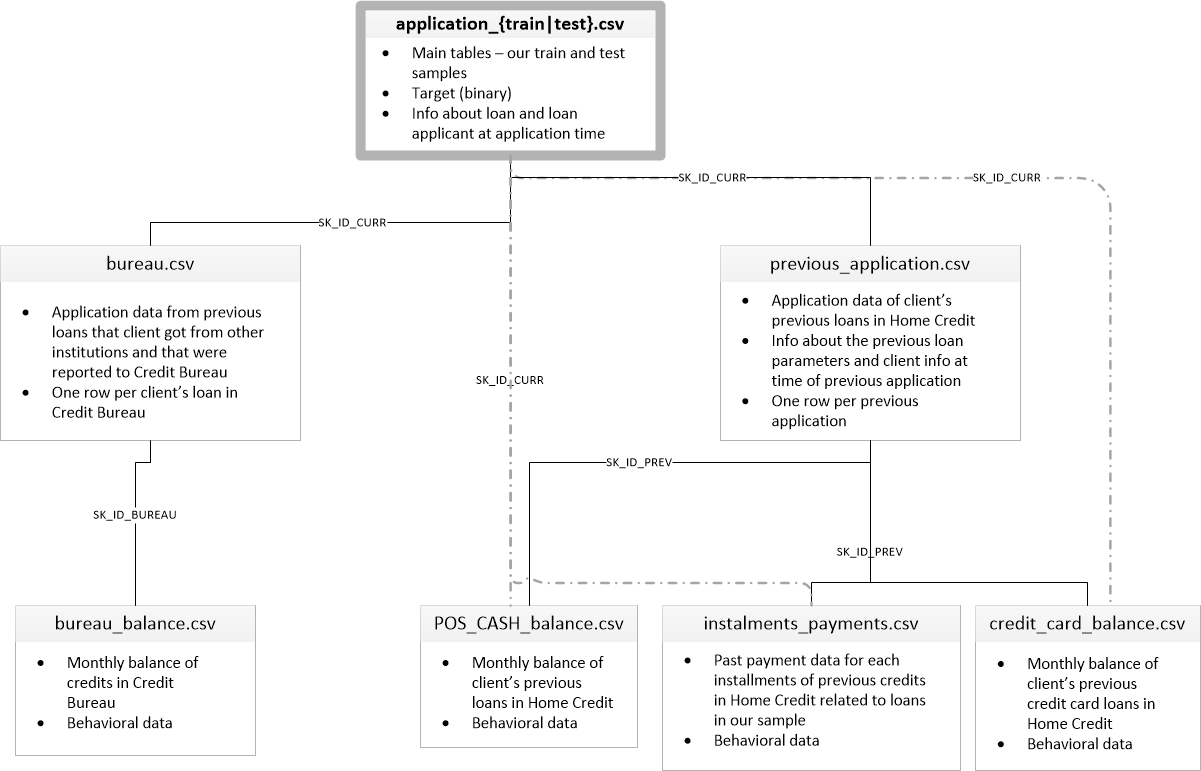



# Initial settings

Prior to any computation, let us deal with required imports and create a Spark session, 
as well as defining useful functions.

**Additional packages**

If we need, we can install more packages, e.g. matplotlib.
We suggest to execute the commands in a Terminal.

Furthermore, it is worth checking commands to deal with installing packages in the environment. For example:

1. List all packages in the current environment: `conda list`
2. List all packages installed into the environment `pyspark_env`: `conda list -n pyspark_env`
3. Save packages for future use: `conda list –export > package-list.txt`
4. Reinstall packages from an export file: `conda create -n pyspark_env –file package-list.txt`

In [1]:
import findspark, pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [2]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Create the Spark session

findspark.init()
findspark.find()

spark = SparkSession\
        .builder\
        .appName("HomeCreditDefaultRisk")\
        .config("spark.sql.shuffle.partitions",6)\
        .config("spark.sql.repl.eagereval.enabled",True)\
        .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/13 23:26:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
import sys

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [6]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

# Useful functions

The visualization functions below rely on Seaborn to plot data but as Python data frame.

See https://seaborn.pydata.org/index.html

We encourage you to use your own plotting functions. Remember: *"A picture is worth a thousand words"*


In [7]:
def plotHorizBar(df, xcol, ycol, colour): 
    return sns.barplot(data=df, x=xcol, y=ycol, color=colour)

In [8]:
def plotLine(df, xcol, ycol):
    return sns.lineplot(data=df, x=xcol, y=ycol)

In [9]:
def plotBar(df, xcol, ycol, huecol=None):
    return sns.barplot(data=df, x=xcol, y=ycol, hue=huecol)

In [10]:
def plotScatter(df, xcol, ycol, huecol=None):
    return sns.scatterplot(data=df, x=xcol, y=ycol, hue=huecol)

In [11]:
def plotScatterMatrix(df, huecol=None):
    return sns.pairplot(data=df, hue=huecol)

In [12]:
def plotCorrelationMatrix(df, annot=False):
    # compute the correlation matrix
    corr = df.corr()
    
    # generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # generate a custom colormap
    #cmap = sns.divergent_palette(230, 20, as_cmap=True)
    
    cmap='coolwarm'

    # draw the heatmap with the mask and correct aspect ratio
    return sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=annot,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [13]:
def plotBox(df, xcol, ycol, huecol=None, kind='box'):
    return sns.catplot(data=df, x=xcol, y=ycol, hue=huecol, kind=kind)

In [14]:
# Function to get columns of numeric type in a DataFrame

def numeric_columns(df):
    cls_numeric = []
    for x, t in df.dtypes:
        if t in ['int', 'double']:
            cls_numeric.append(x)
    return cls_numeric

In [15]:
# Function to figure out the profile of nulls and uniques for ecah column in a DataFrame

def compute_nulls_and_uniques(df, cols):
    total = df.count()
    results = []
    for cl in cols:
        knulls = df.select(cl).filter(F.col(cl).isNull()).count()
        knullsperc = knulls / total
        knans = df.select(cl).filter(F.isnan(cl)).count()
        knansperc = knans / total
        kuniques = df.select(cl).distinct().count()
        kuniquesperc = kuniques / total
        results.append(Row(feature = cl, count_nulls = knulls, percentage_nulls = knullsperc,
                           count_nans = knans, percentage_nans = knansperc,
                           count_uniques = kuniques, percentage_uniques = kuniquesperc))

    return spark.createDataFrame(results)

# Collect and label data

## Data ingestion

In [ ]:
pwd

In [17]:
data_dir = 

In [ ]:
ls -la $data_dir

In [ ]:
# Alternative command to list data files

print(os.listdir(data_dir))

In [20]:
! head -n 2 

Id,Table,Row,Description,Special
1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,


In [21]:
! head -n 2 

SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APART

In [22]:
! head -n 2 

SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_M

## Reading the datasets

In [23]:
filename = data_dir + "HomeCredit_columns_description.csv"
df_HomeCredit_columns_description = spark.read.csv(filename, header="true", inferSchema="true", sep=',')

In [24]:
filename = data_dir + "application_test.csv"
df_application_test =

In [25]:
filename = data_dir + "application_train.csv"
df_application_train =

## Checking data
Schema, show and count

root
 |-- Id: integer (nullable = true)
 |-- Table: string (nullable = true)
 |-- Row: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Special: string (nullable = true)

+---+----------------------------+--------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|Id |Table                       |Row                       |Description                                                                                                                                                                                |Special                              |
+---+----------------------------+--------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------

219

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AG

24/03/13 23:26:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+----------+------+------------------+-----------+------------+---------------+------------+----------------+----------+-----------+---------------+---------------+--------------------+--------------------+--------------------+-----------------+--------------------------+----------+-------------+-----------------+---------------+-----------+----------+--------------+---------------+----------------+----------+----------+---------------+---------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+--------------------+-------------------+-------------------+-------------------+--------------+----------------+---------------------------+------------------+--------------+-------------+-------------+-------------+-------------+------------+--------------------+--------------+------------

307511

root
 |-- SK_ID_CURR: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integer (nullable = true)
 |-- OWN_CAR_AGE: double (nullable = true)
 |-- FLAG_M

48744

In [ ]:
df_HomeCredit_columns_description.select("Table").distinct().show(truncate=False)

In [30]:
df_HomeCredit_columns_description.filter

+---+----------------------------+----------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------+
|Id |Table                       |Row                         |Description                                                                                                                                                                                                                                                                         |Special                              |
+---+----------------------------+----------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Explore and evaluate data

Let us get some data insight, with some **exploratory data analysis** based on descriptive statistics and visualizations.

The dataframes of concern are the ones from the {train/test} data files.

**Note on data quality profiling and exploratory data analysis**

There is an interesting tool to profile dataframes but unfortunately as it stands the Python version we are using now is higher than the ones accepted by the tool. 
> See https://docs.profiling.ydata.ai/latest/


## Datatypes

## Nulls, NaN and uniques

Identify number of nulls or NaN in columns as well uniques. This is helpful to further investigating features of concern.

In [31]:
df_application_train.

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

In [32]:
cols_to_check = ['SK_ID_CURR',
                 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 ]


In [33]:
df_train_nulls_uniques = compute_nulls_and_uniques(df_application_train, cols_to_check)

In [34]:
df_train_nulls_uniques.

+---------------------------+-----------+---------------------+----------+---------------+-------------+---------------------+
|feature                    |count_nulls|percentage_nulls     |count_nans|percentage_nans|count_uniques|percentage_uniques   |
+---------------------------+-----------+---------------------+----------+---------------+-------------+---------------------+
|SK_ID_CURR                 |0          |0.0                  |0         |0.0            |307511       |1.0                  |
|TARGET                     |0          |0.0                  |0         |0.0            |2            |6.503832383231819E-6 |
|NAME_CONTRACT_TYPE         |0          |0.0                  |0         |0.0            |2            |6.503832383231819E-6 |
|CODE_GENDER                |0          |0.0                  |0         |0.0            |3            |9.755748574847729E-6 |
|FLAG_OWN_CAR               |0          |0.0                  |0         |0.0            |2            |6.50383

In [ ]:
# Taking the decision to forget some columns.
#
# Let us simply forget those columns with nulls, 
# so leaving by now considerations like imputing data or dropping records

cols_to_forget = ['AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'OWN_CAR_AGE', 
                    'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'EXT_SOURCE_1','EXT_SOURCE_2','EXT_SOURCE_3']
cols_interest = [c for c in cols_to_check if c not in cols_to_forget] 
cols_interest


## Summary to figure out outliers
Summary of values for columns of interest. Use of describe() or summary() 

In [36]:
df_application_train.

+-------+------------------+-------------------+------------------+-----------+------------+---------------+------------------+------------------+-----------------+----------------+--------------------+------------------+-----------------+--------------------------+-------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+---------------------------+--------------------------+-----------------------+--------------------------+--------------------------+---------------------------+----------------------+----------------------+-----------------------+-----------------+
|summary|        SK_ID_CURR|             TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|      CNT_CHILDREN|  AMT_INCOME_TOTAL|       AMT_CREDIT|NAME_INCOME_TYPE| NAME_EDUCATION_TYPE|NAME_FAMILY_STATUS|NAME_HOUSING_TYPE|REGION_POPULATION_RELATIVE|

# Feature Engineering

Now we have to prepare data in a way that it can be properly used by ML algorithms, which includes selection and extraction of features, as well as dealing with poor data quality if that is the case.


## Saving clean data

Saving data for further use if needed. 

In [ ]:
cols_interest_test = [c for c in cols_interest if c != 'TARGET']
cols_interest_test

In [38]:
# Drop columns that will not be used anymore
# ... or select just the ones of interest
df_application_train = df_application_train.select(cols_interest)
df_application_test = df_application_test.select(cols_interest_test)

In [39]:
# We should also have a smaller dataset to set up the model,
# just for the purpose of working locally

# and we should understand the implications of sampling

seed = 5
with_replacement = False
fraction = 0.3          # reduce to 30%
df_application_train_small = df_application_train.sample(withReplacement=with_replacement, 
                                               fraction=fraction, seed=seed)

In [40]:
[df_application_train.count(), df_application_train_small.count(), df_application_test.count()]

[307511, 92075, 48744]

In [41]:
# Save the data frames to files in parquet for future use in case of need

df_application_train.write.mode("overwrite").parquet("application_for_model")
df_application_train_small.
df_application_test.

# and later on, we can use spark.read.parquet() to load files

24/03/13 23:27:01 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers
24/03/13 23:27:02 WARN MemoryManager: Total allocation exceeds 95.00% (1,020,054,720 bytes) of heap memory
Scaling row group sizes to 95.00% for 8 writers


In [ ]:
ls -la application_for_model

In [ ]:
ls -la application_for_model_small

In [ ]:
ls -la application_for_test

## Data for the model hereafter

In [45]:
df_for_model = df_application_train
# df_for_model = df_application_train_small

In [46]:
# Delete memory consuming variables that are no longer needed

# del 


## Final overview regarding data to be used in the model
After establishing the clean data to be used, let us get an overview about what we have achieved, with some statistics and visualizations. Now we may look at specific columns in more detail.

### Descriptive statistics 

In [47]:
cols_numeric = numeric_columns(df_for_model)

In [48]:
# Just to check that there are no nulls or NaN

for cl in df_for_model.columns:
    knulls_nans = df_for_model.select(cl).filter(F.col(cl).isNull() | F.isnan(cl)).count()
    if knulls_nans > 0:
        print(f"Warning: Feature {cl} has got {knulls_nans} rows with nulls or NaN in the data for building the model.")
    

In [49]:
# Features with not many distinct values (see above)

cls_1 = [
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY'
]

In [50]:
print('\nShowing a few uniques:')
for cl in cls_1:
    df_for_model.


Showing a few uniques:
+------------------+
|NAME_CONTRACT_TYPE|
+------------------+
|Cash loans        |
|Revolving loans   |
+------------------+

+-----------+
|CODE_GENDER|
+-----------+
|F          |
|M          |
|XNA        |
+-----------+

+------------+
|FLAG_OWN_CAR|
+------------+
|N           |
|Y           |
+------------+

+---------------+
|FLAG_OWN_REALTY|
+---------------+
|N              |
|Y              |
+---------------+

+------------+
|CNT_CHILDREN|
+------------+
|0           |
|1           |
|2           |
|3           |
|4           |
|5           |
|6           |
|7           |
|8           |
|9           |
|10          |
|11          |
|12          |
|14          |
|19          |
+------------+

+--------------------+
|NAME_INCOME_TYPE    |
+--------------------+
|Businessman         |
|Commercial associate|
|Maternity leave     |
|Pensioner           |
|State servant       |
|Student             |
|Unemployed          |
|Working             |
+----------

### Correlations

In [51]:
# Checking correlations among some columns
#
# Correlation needs vectors so we convert to vector column first
# See VectorAssembler in the Spark's documentation

# The columns to compute correlations - numeric types but no nulls
cols_corr = cols_numeric

# Assemble columns
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=cols_corr, outputCol=vector_col, handleInvalid = "skip")  # "keep"
df_vector = assembler.transform(df_for_model).select(vector_col)

# Get correlation matrix - it can be Pearson’s (default) or Spearman’s correlation

# corr = Correlation.corr(df_vector, vector_col).head()
# print("Pearson correlation matrix:\n" + str(corr[0]))

# corr = Correlation.corr(df_vector, vector_col, "spearman").head()
# print("Spearman correlation matrix:\n" + str(corr[0]))

corr_matrix = Correlation.corr(df_vector, vector_col).collect()[0][0].toArray().tolist()
# corr_matrix


24/03/13 23:27:22 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [ ]:
# Plot computed correlation

df_plot = pd.DataFrame(data = corr_matrix, index=cols_corr, columns=cols_corr)
plotCorrelationMatrix(df_plot, annot=True)
plt.title('Correlations among numerical features')
plt.show()

### Overall picture

Besides the correlation matrix above, we are going to view and/or visualize data to learn more about the data.

Feel free to add and/or remove visualizations.


In [53]:
# Counting of the dependent variable TARGET

df_for_model.

+------+------+
|TARGET| count|
+------+------+
|     1| 24825|
|     0|282686|
+------+------+



The counting above shows a clear imbalance in the distribution of the dependent variable TARGET: 
The critical class 1 is significantly less frequently than class 0.

Recalling the description of the target variable:
- 1 - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y 
installments of the loan in our sample
- 0 - all other cases


In [ ]:
#  Type of contract

df_plot = df_for_model.groupBy('NAME_CONTRACT_TYPE').count().toPandas()
plotBar(df_plot, 'NAME_CONTRACT_TYPE', 'count')
plt.title('Type of contract')
plt.show()

In [55]:
df_plot.head()

,NAME_CONTRACT_TYPE,count
0,Cash loans,278232
1,Revolving loans,29279


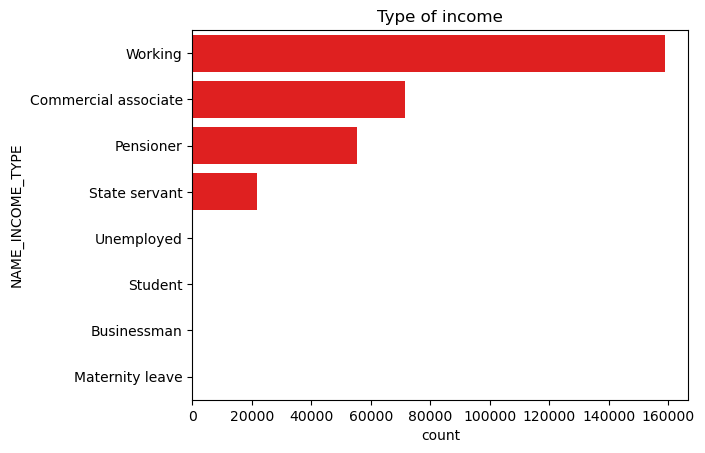

In [56]:
# Type of income

df_plot = (

    
          )
plotHorizBar(df_plot, 'count', 'NAME_INCOME_TYPE', 'red')
plt.title('Type of income')
plt.show()

In [57]:
df_plot.head()

,NAME_INCOME_TYPE,count
0,Working,158774
1,Commercial associate,71617
2,Pensioner,55362
3,State servant,21703
4,Unemployed,22


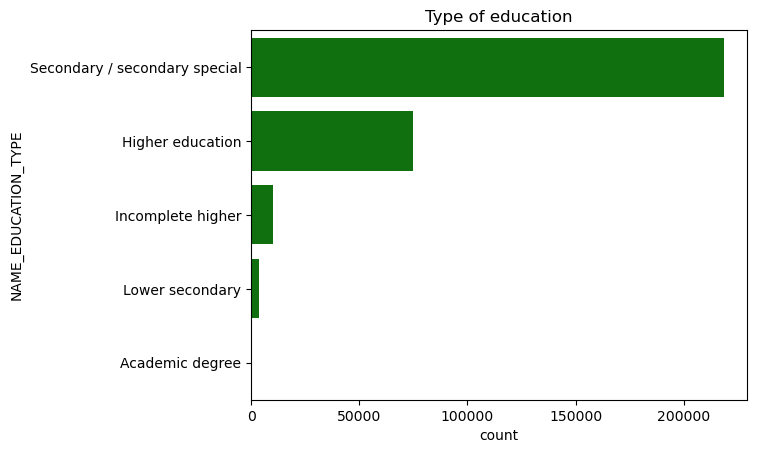

In [58]:
# Type of education

df_plot = ( 


    
          )
plotHorizBar(df_plot, 'count', 'NAME_EDUCATION_TYPE', 'green')
plt.title('Type of education')
plt.show()

In [59]:
df_plot.head()

,NAME_EDUCATION_TYPE,count
0,Secondary / secondary special,218391
1,Higher education,74863
2,Incomplete higher,10277
3,Lower secondary,3816
4,Academic degree,164


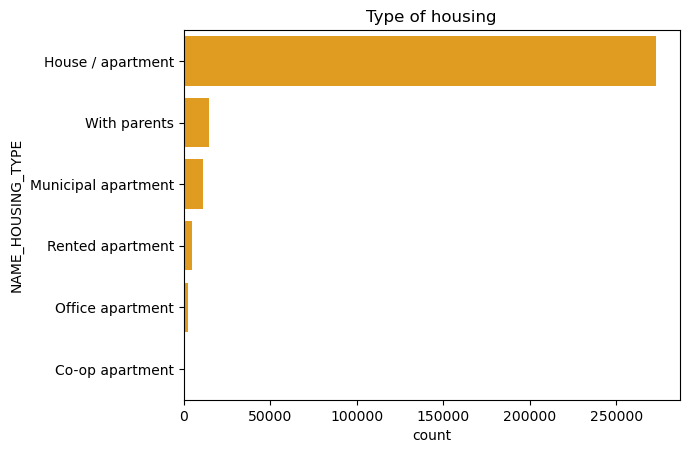

In [60]:
# Type of housing

df_plot = ( 


    
          )
plotHorizBar(df_plot, 'count', 'NAME_HOUSING_TYPE', 'orange')
plt.title('Type of housing')
plt.show()

In [61]:
df_plot.head()

,NAME_HOUSING_TYPE,count
0,House / apartment,272868
1,With parents,14840
2,Municipal apartment,11183
3,Rented apartment,4881
4,Office apartment,2617


## Columns selection, encoding and vector assembling

It is time to start thinking about which features/columns to use in the model, whether existing or new derived ones. To do so, the best we understand what the business is all about the better, including in relation to the characteristics of the data we are given. Statistics that we have made, and more we might do, would help to figure out patterns of interest.

Once the columns of interest for the classifer are set out, we have to enter into the specifics of the algorithms. 

We are going to use `StringIndexer` and `OneHotEncoder`, as the ML algorithms we are about to use do require processing numbers not text. And because of those algorithms also requiring that all input features are contained within a single vector, we need a transformation. So we use the `VectorAsAssembler` transformer, already used above.

In order to select the features to use, one should also take into account the correlations among them. 
But as a starting experiment, let us use as many as possible.

Also, we have to make sure that the column target (binary label) is of numeric type. That is the case: `TARGET`.

**Notes**:
- MLlib provides a set of tools to help tackling this issue of features. See http://spark.apache.org/docs/latest/ml-features.html .
- Another useful Spark's functionality is Imputer, which completes missing values in a dataset, using the mean, median or mode of the columns in which the missing values are located. The input columns have to be of numeric type. At this moment, there is not need given that we have excluded (wrongly) problematic columns. More on that in the section below regarding additional exercises.

In [62]:
cols_numeric

['SK_ID_CURR',
 'TARGET',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [63]:
cols_not_features = ['SK_ID_CURR', 'TARGET'] 

cols_non_numeric = [c for c in df_for_model.columns if c not in cols_numeric]
cols_non_numeric

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [64]:
# Encoding columns and vector assembling them
# See Chapter 10 of the book "Learning Spark - Lightning-Fast Data Analytics"

categorical_cols = [i for i in cols_non_numeric if i not in cols_not_features]
non_categorical_cols = [i for i in cols_numeric if i not in cols_not_features]

index_output_cols = [x + ' Index' for x in categorical_cols]
ohe_output_cols = [x + ' OHE' for x in categorical_cols]

string_indexer = StringIndexer(inputCols=categorical_cols, outputCols=index_output_cols, handleInvalid="skip")

ohe_encoder = OneHotEncoder(inputCols=index_output_cols, outputCols=ohe_output_cols)
   
# Put all input features into a single vector, by using a transformer

assembler_inputs = ohe_output_cols + non_categorical_cols
vec_assembler = VectorAssembler(inputCols=assembler_inputs, outputCol="features")
assembler_inputs

['NAME_CONTRACT_TYPE OHE',
 'CODE_GENDER OHE',
 'FLAG_OWN_CAR OHE',
 'FLAG_OWN_REALTY OHE',
 'NAME_INCOME_TYPE OHE',
 'NAME_EDUCATION_TYPE OHE',
 'NAME_FAMILY_STATUS OHE',
 'NAME_HOUSING_TYPE OHE',
 'WEEKDAY_APPR_PROCESS_START OHE',
 'ORGANIZATION_TYPE OHE',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

In [65]:
categorical_cols

['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE']

In [66]:
non_categorical_cols

['CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY']

# Select and train model

Now it is time to train and test a model to be used for binary classification, that is, to decide whether there is a fraud or not.

We are going to use a Linear Support Vector Machine algorithm, as presented in

>http://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine . 

But at this point in time, probably it is worth considering to look at both the supervised learning and the ML pipeline slides from the lectures.

## Partitioning of data

The step of creating a ML model means we should keep some part of the data in the dark.
Basic standard split is 80/10/10 (or 70/15/15 if dataset is large), assuming a train/validation/test split. 

Recall that if the validation part is relatively too small, then the model will memorize the data so it will reach an overfit situation. That would be bad as it no longer have data to evaluate how well it will generalize to unseen data. So, model performance is usually measured against a held-out test set consisting of examples that have never been seen before.

Also, notice that data highlighting dificluties in payments is less and imbalanced. Ideally, we should carry out better tuning for the data split, as it affects the performance of the model.

Hence, we will consider the following:

- Training dataset: 80% of examples used for model training
- Validation dataset: 20% to validate our models after the training and possibly decide on changes
- Test dataset: the dataset provided for test

In [67]:
# train/validation split

df_train, df_validation = df_for_model.randomSplit([0.8, 0.2], 42) 

# Caching data ... just the training part as it is accessed many times by the algorithm
# But, it might not be a good idea if we are using a local computer and large dataset!
# df_train.cache()

# Print the number of rows in each part
print(f"There are {df_train.count()} rows in the training set and {df_validation.count()} in the validation set.")


There are 246240 rows in the training set and 61271 in the validation set.


**Notice:** 

As we did before, we may consider storing the data split into files, should we want to use it elsewhere. 

This relates to the need of guaranteeing unicity in a different environment. 
We leave it as it is now.

In [68]:
# Linear SVC algorithm
# default: featuresCol='features', labelCol='label', predictionCol='prediction'

lsvc = LinearSVC(maxIter=10, regParam=0.1, labelCol='TARGET')


## ML pipeline configuration

In [69]:
# The pipeline holds four stages as set above: 
#  1. string_indexer 
#  2. ohe_encoder
#  3. vec_assembler (related to assembling features into vector) 
#  4. lsvc (related to ML estimator)

pipeline = Pipeline(stages=[string_indexer, ohe_encoder, vec_assembler, lsvc])


## Model fitting
Get the model (as transformer) by fitting the pipeline to the training data.

In [70]:
pipeline_model = pipeline.fit(df_train)


# Evaluate model

Let us evaluate the Linear SVM model that has been built.

## Validating the model

It is time to apply the model built to validation data. Again, we will use the pipeline set above, meaning the stages already specified will be reused. Notice that, since the pipeline model is a transformer, we can easily apply it to validation data.

In [ ]:
# Make predictions on validation data and show values of columns of interest

df_prediction = pipeline_model.transform(df_validation)

# Check its schema

df_prediction.printSchema()


In [ ]:
# Columns to be focus on

df_prediction.select('features', 'rawPrediction', 'prediction', 'TARGET').show(truncate=False) 


## Evaluation metrics

How right is the model? Let us start to figure out by using:
1. Specific evaluator
2. Confusion matrix


In [73]:
# Compute evaluation metrics on test data

prediction_label = df_prediction.select('rawPrediction', 'prediction', 'TARGET')  

# supports metricName="areaUnderROC" (default) and "areaUnderPR"
# it relates to sensitivity (TP rate) and specificity (FP rate)

evaluator = BinaryClassificationEvaluator(labelCol='TARGET')

print("areaUnderROC = " + str(evaluator.evaluate(prediction_label)))
# print("areaUnderPR = " + str(evaluator.evaluate(prediction_label, {evaluator.metricName: 'areaUnderPR'})))


areaUnderROC = 0.600860425038266


Recalling the confusion matrix:

- True Positive: the prediction was positive and it is true. 
- True Negative: the prediction was negative and it is true. 
- False Positive: the prediction was positive and it is false. 
- False Negative: the prediction was negative and it is false. 


 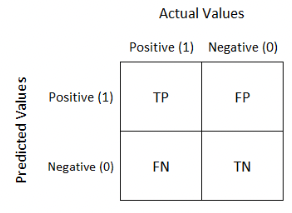

It follows the TP, TN, FP and FN computations.

In [74]:
# Counting rows for each case TP, TN, FP and FN respectively

n = df_prediction.count()
tp = df_prediction.filter(F.expr('prediction > 0') & F.expr('TARGET == prediction')).count()
tn = df_prediction.filter(                 ).count()
fp = df_prediction.filter(                 ).count()
fn = n - tp - tn - fp
[tp, tn, fp, fn, n]


[1, 56209, 0, 5061, 61271]

**Accuracy** = (TP + TN) / (TP + TN + FP + FN)

How often the classifier is correct? (score)

Metric widely used but not so useful when there are many TN cases.

In [75]:
accuracy = (tp + tn) / (tp + tn + fp + fn)

**Precision** = TP / (TP + FP)

Positive predictive value - proportion of positive results that were correctly identified.

It removes NP and FN from consideration.

In [76]:
precision = tp / (tp + fp)

**Recall** = TP / (TP + FN)

True positive rate. (hit rate, sensitivity)

In [77]:
recall = tp / (tp + fn)

**Specifity** = TN / (TN + FP)

True negative rate. (selectivity)

In [78]:
specificity = tn / (tn + fp)

**F1 score** = 2 * Recall * Precision / (Recall + Precision)

Useful metric because it is difficult to compare two models with low precision and high recall or vice versa. 
Indeed, by combining recall and precision it helps to measure them at once.


In [79]:
f1_score = 2 * recall * precision / (recall + precision)

In [80]:
# Confusion matrix conclusions

print("TP = {}, TN = {}, FP = {}, FN = {}, Total = {}".format(tp, tn, fp, fn, n)) 
print("Accuracy = {}".format(accuracy))
print("Precison = {}".format(precision))
print("Recall = {}".format(recall))
print("Specificity = {}".format(specificity))
print("F1 score = {}".format(f1_score))

TP = 1, TN = 56209, FP = 0, FN = 5061, Total = 61271
Accuracy = 0.9173997486576031
Precison = 1.0
Recall = 0.00019755037534571315
Specificity = 1.0
F1 score = 0.0003950227138060438


**Considerations:**

1. *Which of the above metrics are most relevant for performance analysis in this particular study, considering the dataset that has been used?*

Classification of rare events is challenging in imbalanced datasets, as the TARGET variable highlights. 
In such scenarios, it is better to use the metric *area under the receiver operating characteristic curve (AUC)*, which evaluates ranking ability and it is particularly relevant in distinguishing between classes in imbalanced contexts. 
AUC measures the trade-off between the true positive rate and the false positive rate, so providing a more nuanced understanding of a model's capacity to identify rare events. 

Notice that the metric *accuracy* for example reflects overall prediction correctness but it can be misleading by not accounting adequately for the performance on minority classes.  

2. *Precision is very low due to the fact that the dataset is imbalanced, with true negatives having a much larger number of instances than true positives. In order to further improve results, it would be nice to train the model on more balanced datasets.* 

## Visual analysis
Plotting `prediction` obtained above versus `TARGET` .

In [81]:
# Plots

# We leave it as exercise

## Saving the pipeline

In [82]:
# We can save the pipeline for further use should it be required

pipeline.save("pipeline-LinearSVM")

# later on, it can be loaded anywhere


In [83]:
# Furthermore, we can save the pipeline after fit, that is, the model

pipeline_model.

In [ ]:
ls -la

In [ ]:
ls -la pipeline-LinearSVM

# Tune model

We should improve the model. For example, we can think about:
- How can we interpret the scores above?
- How to handle class imbalance, so clear in this dataset?
- Could a model with different set of features and/or target engineering would perform better? 
- And what about using real-time data, that is, not training nor validation data? At least we must apply now the model to the test dataset considered earlier on.

# Additional exercises

## Test validation
To follow up the code above, now we can figure out how the model that has been built will perform against the given test dataset.

To do so, you may continue working in this notebook or create a new one for the purpose. Recall that
- the model is already stored in file;
- the test dataset is also stored in file, and accordingly to the train dataset that has been used for building the model.

## ML model improvement
Create one or more notebooks with similar implementation as this one but using
the following classifiers instead:
1. Logistic Regression 
2. Decision Tree

Also, try to improve the process of feature/target engineering, given the framework set out. By the way, you should take into account correlations among features. Also, you may include in the model some features that were not used so far, like EXT_SOURCE_1, EXT_SOURCE_2, and EXT_SOURCE_3.

See related information in:

http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression (http://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression)

http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier (http://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier)


## Profile of applicants of housing credits

Using also other datasets you find in the given zip archive, create a new notebook to profile applicants of housing credits.
Make sure you have a careful working plan in order to reach the goals.


# References

* Learning Spark - Lightning-Fast Data Analytics, 2nd Ed. J. Damji, B. Wenig, T. Das, and D. Lee. O'Reilly, 2020
* http://spark.apache.org/docs/latest/ml-guide.html
* https://docs.python.org/3/ 
* https://www.kaggle.com/competitions/home-credit-default-risk/
